# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

**Disclaimer:** This notebook was primarily generated by an AI assistant. While it aims to demonstrate how to access and explore the data, it has not been rigorously verified by human experts. Please use caution when interpreting the code and results. Independent verification is recommended.

## Overview

This notebook explores Dandiset [000690](https://dandiarchive.org/dandiset/000690), titled "Allen Institute Openscope - Vision2Hippocampus project".

**Description from Dandiset metadata:**
> Extensive research shows that visual cortical neurons respond to specific stimuli, e.g. the primary visual cortical neurons respond to bars of light with specific orientation. In contrast, the hippocampal neurons are thought to encode not specific stimuli but instead represent abstract concepts such as space, time and events. How is this abstraction computed in the mouse brain? Specifically, how does the representation of simple visual stimuli evolve from the thalamus, which is a synapse away from the retina, through primary visual cortex, higher order visual areas and all the way to hippocampus, that is farthest removed from the retina? The current OpenScope project aims to understand how the neural representations of simple and natural stimuli evolve from the LGN through V1, and most hippocampal regions, as well as some of the frontal areas. Stimuli presented included simple visual motion (bars of light) and complex visual stimuli (movies involving eagles/squirrels). Data includes Neuropixel extracellular electrophysiology recordings from various brain regions in mice.

**Keywords:** mouse, neuropixel, extracellular electrophysiology, neocortex, hippocampus, Entorhinal cortex, excitatory, inhibitory, vision, movies

## Goal of this Notebook

This notebook demonstrates how to:
1.  Use the DANDI API to access metadata about the Dandiset.
2.  List assets (files) within the Dandiset.
3.  Load a specific Neurodata Without Borders (NWB) file from the Dandiset remotely using `pynwb`, `h5py`, and `remfile`.
4.  Access basic metadata within the NWB file.
5.  Load and visualize example data, including:
    *   Running speed of the mouse.
    *   Spike times from a single recorded unit.
    *   Information about stimulus presentations.
6. Provide a link to explore the NWB file interactively on Neurosift.

## Required Packages

To run this notebook, you'll need the following Python packages installed. We assume these are already available in your environment.

*   `dandi` (for interacting with the DANDI Archive API)
*   `pynwb` (for working with NWB files)
*   `h5py` (dependency for `pynwb` to handle HDF5 data)
*   `remfile` (for streaming remote HDF5 files)
*   `numpy` (for numerical operations)
*   `matplotlib` (for plotting)
*   `pandas` (for tabular data handling)
*   `seaborn` (for enhanced plotting)

**Note:** No installation commands are included here. Please ensure these packages are installed in your Python environment.

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pynwb
import h5py
import remfile
import warnings

# Import DANDI API client
from dandi.dandiapi import DandiAPIClient

# Import seaborn for plotting styles
import seaborn as sns
sns.set_theme()

# Ignore specific warnings that can occur with NWB/HDF5 loading
warnings.filterwarnings("ignore", message="Ignoring cached namespace.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Limited Linearization.*", category=UserWarning)

## 1. Load Dandiset Information using DANDI API

We can use the `DandiAPIClient` to connect to the DANDI Archive and retrieve metadata about the Dandiset.

In [2]:
# Connect to DANDI archive
try:
    client = DandiAPIClient()
    dandiset = client.get_dandiset("000690", "draft") # Using 'draft' version

    # Print basic information about the Dandiset
    metadata = dandiset.get_raw_metadata()
    print(f"Dandiset name: {metadata.get('name', 'N/A')}")
    print(f"Dandiset URL: {metadata.get('url', 'N/A')}")
    print(f"Description: {metadata.get('description', 'N/A')}")

    # List some assets in the Dandiset
    print("\nListing some assets...")
    asset_count = 0
    for asset in dandiset.get_assets():
        print(f"- {asset.path} (ID: {asset.asset_id})")
        asset_count += 1
        if asset_count >= 5: # Limit the output for brevity
            break
    print(f"\n... found at least {asset_count} assets (listing limited).")

except Exception as e:
    print(f"Error connecting to DANDI or retrieving Dandiset info: {e}")
    print("Proceeding with hardcoded values for demonstration.")
    dandiset = None # Ensure dandiset is None if API fails

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/draft
Description: Extensive research shows that visual cortical neurons respond to specific stimuli, e.g. the primary visual cortical neurons respond to bars of light with specific orientation. In contrast, the hippocampal neurons are thought to encode not specific stimuli but instead represent abstract concepts such as space, time and events. How is this abstraction computed in the mouse brain? Specifically, how does the representation of simple visual stimuli evolve from the thalamus, which is a synapse away from the retina, through primary visual cortex, higher order visual areas and all the way to hippocampus, that is farthest removed from the retina?

The current OpenScope project aims to understand how the neural representations of simple and natural stimuli evolve from the LGN through V1, and most hippocampal regions, as well as some of the frontal areas.

## 2. Select and Load an NWB File

This Dandiset contains multiple NWB files representing different subjects, sessions, and data types (e.g., raw ecephys, imaging). We will select one specific NWB file for demonstration purposes.

We will load the file: `sub-692072/sub-692072_ses-1298465622.nwb`.

The Asset ID for this file is `fbcd4fe5-7107-41b2-b154-b67f783f23dc`.
We construct the download URL using this Asset ID:
`https://api.dandiarchive.org/api/assets/<ASSET_ID>/download/`

We use `remfile` to stream the file content without downloading the entire file, and `pynwb` with `h5py` to read the NWB structure.

In [3]:
# Define the URL for the selected NWB asset
# Asset Path: sub-692072/sub-692072_ses-1298465622.nwb
asset_id = "fbcd4fe5-7107-41b2-b154-b67f783f23dc"
dandiset_id = "000690"
dandiset_version = "draft"
nwb_url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"

print(f"Attempting to load NWB file from: {nwb_url}")

# Construct the Neurosift URL
neurosift_url = f"https://neurosift.app/nwb?url={nwb_url}&dandisetId={dandiset_id}&dandisetVersion={dandiset_version}"
print(f"\nExplore this file interactively on Neurosift: {neurosift_url}")

# Load the NWB file using remfile for remote access
try:
    # Create a remfile object for the URL
    remote_file = remfile.File(nwb_url)
    
    # Create an h5py File object using the remfile
    h5_file = h5py.File(remote_file, 'r')
    
    # Use pynwb to read the NWB data from the h5py File object
    io = pynwb.NWBHDF5IO(file=h5_file, mode='r', load_namespaces=True) # load_namespaces=True helps avoid warnings
    nwb = io.read()
    
    print("\nNWB file loaded successfully.")
    
    # Display some basic metadata from the NWB file
    print(f"\nSession Description: {nwb.session_description}")
    print(f"Identifier: {nwb.identifier}")
    print(f"Session Start Time: {nwb.session_start_time}")
    print(f"Subject ID: {nwb.subject.subject_id if nwb.subject else 'N/A'}")
    print(f"Available Acquisition Objects: {list(nwb.acquisition.keys())}")
    print(f"Available Processing Modules: {list(nwb.processing.keys())}")
    print(f"Available Stimulus Intervals: {list(nwb.intervals.keys())}")

except Exception as e:
    print(f"\nError loading NWB file: {e}")
    print("Further analysis requiring the NWB object will be skipped.")
    nwb = None # Ensure nwb is None if loading fails
    io = None # Ensure io is None if loading fails
    h5_file = None # Ensure h5_file is None if loading fails

Attempting to load NWB file from: https://api.dandiarchive.org/api/assets/fbcd4fe5-7107-41b2-b154-b67f783f23dc/download/

Explore this file interactively on Neurosift: https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/fbcd4fe5-7107-41b2-b154-b67f783f23dc/download/&dandisetId=000690&dandisetVersion=draft



NWB file loaded successfully.

Session Description: Data and metadata for an Ecephys session
Identifier: 1298465622
Session Start Time: 2023-09-21 00:00:00-07:00
Subject ID: 692072
Available Acquisition Objects: ['EyeTracking', 'raw_running_wheel_rotation', 'running_wheel_signal_voltage', 'running_wheel_supply_voltage']
Available Processing Modules: ['running', 'stimulus']
Available Stimulus Intervals: ['Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations', 'SAC_Wd15_Vel2_Bndry2_Cntst0_loop_presentations', 'SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations', 'SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations', 'SAC_Wd15_Vel8_Bndry1_Cntst0_loop_presentations', 'SAC_Wd45_Vel2_Bndry1_Cntst0_loop_presentations', 'UD_Wd15_Vel2_Bndry1_Cntst0

## 3. Explore Data: Running Speed

The NWB file contains information about the mouse's running speed, typically found in the `processing` module. Let's load and plot a segment of this data.

The data is located at `nwb.processing['running']['running_speed']`. It's a `TimeSeries` object containing the speed (`data`) and corresponding `timestamps`.

Running speed data shape: (118163,)
Running speed timestamps shape: (118163,)
Running speed unit: cm/s

Plotting the first 2000 points of running speed data.


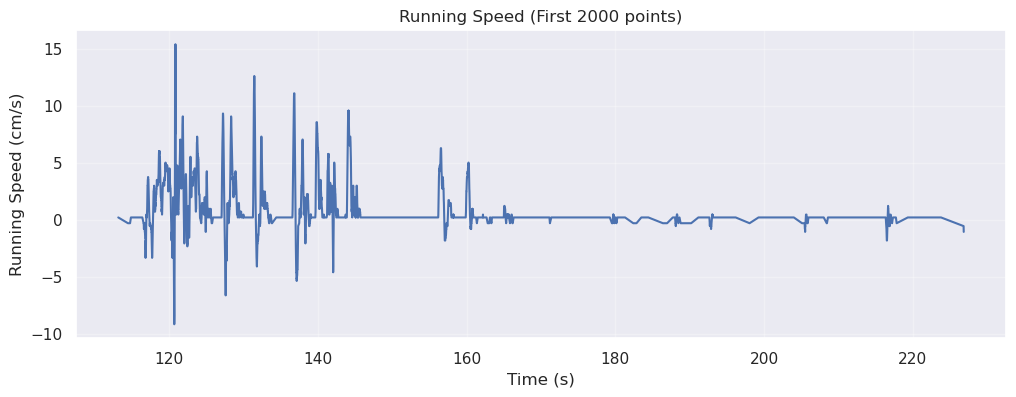

In [4]:
if nwb and 'running' in nwb.processing and 'running_speed' in nwb.processing['running'].data_interfaces:
    try:
        running_speed_ts = nwb.processing['running']['running_speed']
        
        print(f"Running speed data shape: {running_speed_ts.data.shape}")
        print(f"Running speed timestamps shape: {running_speed_ts.timestamps.shape}")
        print(f"Running speed unit: {running_speed_ts.unit}")
        
        # --- Load a SUBSET of the data for plotting ---
        # Loading the entire dataset might be slow over the network.
        num_points_to_plot = 2000 
        if len(running_speed_ts.timestamps) > num_points_to_plot:
            print(f"\nPlotting the first {num_points_to_plot} points of running speed data.")
            time_subset = running_speed_ts.timestamps[:num_points_to_plot]
            speed_subset = running_speed_ts.data[:num_points_to_plot]
        else:
            print("\nPlotting all running speed data points.")
            time_subset = running_speed_ts.timestamps[:]
            speed_subset = running_speed_ts.data[:]
            
        # Ensure data is loaded into memory as numpy arrays for plotting
        time_subset_np = np.array(time_subset)
        speed_subset_np = np.array(speed_subset)

        # Create the plot
        plt.figure(figsize=(12, 4))
        plt.plot(time_subset_np, speed_subset_np)
        plt.xlabel("Time (s)")
        plt.ylabel(f"Running Speed ({running_speed_ts.unit})")
        plt.title(f"Running Speed (First {len(time_subset_np)} points)")
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"Error accessing or plotting running speed data: {e}")
else:
    print("Running speed data not found or NWB file failed to load.")

## 4. Explore Data: Units (Spike Times)

The NWB file also contains sorted spike data in the `units` table. This table includes spike times for different neurons identified during the experiment, along with various quality metrics and properties.

We can access this table via `nwb.units`. Let's view the structure of this table and then plot the spike times for a single unit.

Units table structure (first 5 rows):
    recovery_slope   l_ratio   d_prime  max_drift  firing_rate  \
id                                                               
12       -0.140852  0.000057  6.233920      31.97     1.992914   
13       -0.120064  0.000212  6.380643      33.91     1.516987   
14       -0.061008  0.001185  4.884140      56.95     0.703265   
15       -0.149691  0.002038  5.300020       6.65     0.047692   
16       -0.060737  0.001665  3.732261      39.00     0.766648   

    isi_violations  presence_ratio  spread  velocity_above  \
id                                                           
12        1.224279            0.99    50.0       -0.343384   
13        0.100634            0.99    30.0       -0.343384   
14        2.528098            0.99    40.0        0.206030   
15       20.360357            0.89    30.0        0.343384   
16        0.078791            0.99    30.0       -4.807370   

    repolarization_slope  ...  PT_ratio       snr  nn_hit_rate  

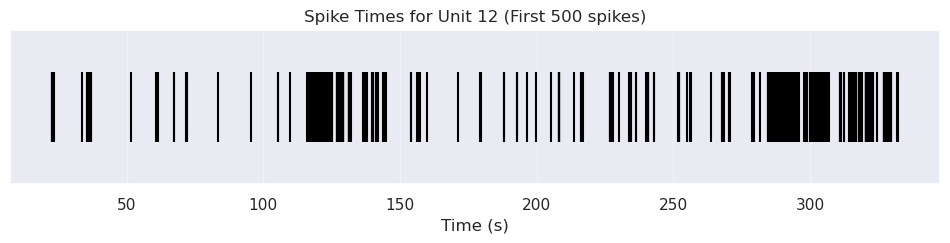

In [5]:
if nwb and nwb.units:
    try:
        # Access the units table
        units_table = nwb.units
        
        # Convert to a pandas DataFrame for easier viewing
        units_df = units_table.to_dataframe()
        
        print("Units table structure (first 5 rows):")
        print(units_df.head())
        
        print(f"\nTotal number of units found: {len(units_df)}")
        
        # --- Select a single unit to plot ---
        if len(units_df) > 0:
            unit_index_to_plot = 0 # Choose the first unit
            unit_id = units_df.index[unit_index_to_plot]
            unit_data = units_df.iloc[unit_index_to_plot]
            
            print(f"\nSelected Unit ID for plotting: {unit_id}")
            print(f"Unit Quality: {unit_data.get('quality', 'N/A')}")
            print(f"Unit Firing Rate: {unit_data.get('firing_rate', 'N/A')}")
            
            # Get spike times for the selected unit
            # The spike_times Series in the DataFrame contains numpy arrays
            spike_times = unit_data['spike_times'] 
            
            print(f"Total spikes for unit {unit_id}: {len(spike_times)}")
            
            # --- Load a SUBSET of spike times for plotting ---
            num_spikes_to_plot = 500
            if len(spike_times) > num_spikes_to_plot:
                print(f"Plotting the first {num_spikes_to_plot} spikes.")
                spike_times_subset = spike_times[:num_spikes_to_plot]
            else:
                print("Plotting all spikes for this unit.")
                spike_times_subset = spike_times[:]
            
            # Ensure data is a numpy array
            spike_times_subset_np = np.array(spike_times_subset)

            # Create a simple raster plot (using eventplot)
            plt.figure(figsize=(12, 2))
            plt.eventplot(spike_times_subset_np, linelengths=0.75, color='black')
            plt.xlabel("Time (s)")
            plt.yticks([]) # Hide y-axis as it's just one unit
            plt.title(f"Spike Times for Unit {unit_id} (First {len(spike_times_subset_np)} spikes)")
            plt.grid(True, axis='x', alpha=0.3)
            plt.show()

        else:
            print("\nNo units found in the table.")

    except Exception as e:
        print(f"Error accessing or plotting unit data: {e}")
        # print traceback if needed
        # import traceback
        # traceback.print_exc()

else:
    print("Units table not found or NWB file failed to load.")

## 5. Explore Data: Stimulus Presentations

The `intervals` section often contains information about experimental epochs, including stimulus presentations. This Dandiset description mentions various visual stimuli (bars, movies). Let's look at one of the stimulus tables.

In [6]:
if nwb and nwb.intervals:
    try:
        # List available interval tables
        print("Available interval tables:")
        interval_keys = list(nwb.intervals.keys())
        for key in interval_keys:
            print(f"- {key}")
        
        # --- Choose one table to display ---
        # Let's pick one related to the 'SAC' stimulus mentioned in the NWB info dump
        table_key_to_show = None
        potential_keys = [k for k in interval_keys if 'SAC' in k and 'presentations' in k]
        if potential_keys:
            table_key_to_show = potential_keys[0] # Pick the first match
        elif interval_keys:
             table_key_to_show = interval_keys[0] # Fallback to the first table if no SAC found
       
        if table_key_to_show:
            print(f"\nShowing structure of interval table: '{table_key_to_show}'")
            stim_table = nwb.intervals[table_key_to_show]
            
            # Convert to pandas DataFrame
            stim_df = stim_table.to_dataframe()
            
            print(f"Table description: {stim_table.description}")
            print("\nFirst 5 rows of the table:")
            print(stim_df.head())
            
            # Show available columns
            print("\nAvailable columns:", list(stim_df.columns))
            
        else:
            print("\nCould not find a suitable stimulus presentation table to display.")

    except Exception as e:
        print(f"Error accessing interval data: {e}")
else:
    print("Intervals data not found or NWB file failed to load.")

Available interval tables:
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations
- SAC_Wd15_Vel2_Bndry2_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations
- SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations
- SAC_Wd15_Vel8_Bndry1_Cntst0_loop_presentations
- SAC_Wd45_Vel2_Bndry1_Cntst0_loop_presentations
- UD_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- acurl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- curl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- invalid_times
- natmovie_CricketsOnARock_540x960Full_584x460Active_presentations
- natmovie_EagleSwooping1_540x960Full_584x460Active_presentations
- natmovie_EagleSwooping2_540x960Full_584x460Active_presentations
- natmovie_SnakeOnARoad_540x960Full_584x460Active_p

Table description: Presentation times and stimuli details for 'Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop' stimuli. 
Note: image_name references control_description in stimulus/templates

First 5 rows of the table:
     start_time    stop_time                           stimulus_name  \
id                                                                     
0   4514.837970  4514.854651  Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop   
1   4514.854651  4514.871333  Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop   
2   4514.871333  4514.888014  Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop   
3   4514.888014  4514.904696  Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop   
4   4514.904696  4514.921377  Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop   

    stimulus_block  frame            color  contrast  opacity  orientation  \
id                                                                           
0             13.0    0.0  [1.0, 1.0, 1.0]       1.0      1.0          0.0   
1             13.0    1.0  [1.0, 1.0, 1.0]       1

## 6. Simple Combined Visualization: Running Speed During a Stimulus Presentation

Let's try to plot the running speed during the first presentation epoch listed in the stimulus table we just examined.

In [7]:
if nwb and 'running' in nwb.processing and 'running_speed' in nwb.processing['running'].data_interfaces and 'stim_df' in locals() and not stim_df.empty:
    try:
        # Get the start and stop time of the first stimulus presentation epoch
        first_epoch = stim_df.iloc[0]
        start_time = first_epoch['start_time']
        stop_time = first_epoch['stop_time']
        stim_name = first_epoch.get('stimulus_name', 'Unknown Stimulus') 
        
        print(f"\nPlotting running speed during the first epoch of '{table_key_to_show}'")
        print(f"Stimulus Name: {stim_name}")
        print(f"Time Window: {start_time:.2f}s - {stop_time:.2f}s")
        
        # Find indices of running speed timestamps within this epoch
        running_speed_ts = nwb.processing['running']['running_speed']
        all_timestamps = running_speed_ts.timestamps # This is an HDF5 dataset
        
        # Efficiently find indices without loading all timestamps into memory at once if possible
        # However, for boolean indexing, loading is often necessary. Let's load carefully.
        # Determine the approximate indices to slice first, then refine.
        # This might still load a significant chunk if the epoch is long or sampling rate high.
        approx_rate = 1 / np.mean(np.diff(all_timestamps[:100])) if len(all_timestamps) > 1 else 1
        start_idx_est = max(0, int((start_time - all_timestamps[0]) * approx_rate) - 100) if len(all_timestamps) > 0 else 0
        stop_idx_est = min(len(all_timestamps), int((stop_time - all_timestamps[0]) * approx_rate) + 100) if len(all_timestamps) > 0 else 0

        if stop_idx_est > start_idx_est:
            print(f"Estimated index range: {start_idx_est} - {stop_idx_est}")
            # Load the relevant slice
            timestamps_slice = all_timestamps[start_idx_est:stop_idx_est]
            
            # Find exact indices within the loaded slice
            epoch_indices_in_slice = np.where((timestamps_slice >= start_time) & (timestamps_slice <= stop_time))[0]
            
            if len(epoch_indices_in_slice) > 0:
                 # Adjust indices back to original full array context if needed for data loading
                epoch_indices_global = epoch_indices_in_slice + start_idx_est
                 
                # Load the corresponding data using these global indices
                # Note: Direct fancy indexing on remote HDF5 datasets can be slow or unsupported.
                # It's often better to slice a contiguous block containing the indices.
                min_idx = np.min(epoch_indices_global)
                max_idx = np.max(epoch_indices_global)
                
                print(f"Loading data slice for indices: {min_idx} - {max_idx}")
                
                # Adjust timestamps and data to the loaded block
                time_epoch = all_timestamps[min_idx:max_idx+1]
                speed_epoch = running_speed_ts.data[min_idx:max_idx+1]

                # Filter again to the exact time window
                final_mask = (time_epoch >= start_time) & (time_epoch <= stop_time)
                time_epoch_final = np.array(time_epoch[final_mask])
                speed_epoch_final = np.array(speed_epoch[final_mask])

                if len(time_epoch_final) > 0:
                    # Create the plot
                    plt.figure(figsize=(12, 4))
                    plt.plot(time_epoch_final, speed_epoch_final)
                    plt.xlabel("Time (s)")
                    plt.ylabel(f"Running Speed ({running_speed_ts.unit})")
                    plt.title(f"Running Speed during first '{stim_name}' epoch ({start_time:.2f}s - {stop_time:.2f}s)")
                    plt.grid(True, alpha=0.3)
                    plt.xlim(start_time, stop_time)
                    plt.show()
                else:
                    print("No running speed data points found within the exact epoch timeframe after slicing.")
            else:
                print("No running speed timestamps found within the specified epoch.")
        else:
             print("Estimated indices are invalid, cannot slice data.")

    except Exception as e:
        print(f"Error during combined visualization: {e}")
        # import traceback
        # traceback.print_exc()
else:
    print("\nSkipping combined visualization: NWB file, running speed data, or stimulus dataframe not available/loaded.")


Plotting running speed during the first epoch of 'Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations'
Stimulus Name: Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop
Time Window: 4514.84s - 4514.85s
Estimated index range: 87272 - 87473
No running speed timestamps found within the specified epoch.


## 7. Summary and Future Directions

This notebook demonstrated the initial steps for exploring Dandiset 000690. We showed how to:
*   Connect to the DANDI Archive and retrieve Dandiset metadata.
*   Select and load a specific NWB file remotely using `remfile`.
*   Access basic metadata within the NWB file (session info, subject).
*   Load and visualize subsets of behavioral data (running speed).
*   Access the `units` table containing spike sorting results and plot spike times for a single unit.
*   Inspect stimulus presentation tables stored in `intervals`.
*   Combine data types for a simple visualization (running speed during a stimulus epoch).

**Future Directions:**

*   **Correlate Neural Activity with Stimuli:** Analyze spike rates of units during different stimulus presentations (e.g., different bar widths, speeds, or movie types) listed in the `intervals` tables.
*   **Correlate Neural Activity with Behavior:** Investigate how neural firing patterns change with the mouse's running speed.
*   **Population Analysis:** Explore the activity across multiple units simultaneously.
*   **Explore Other Data:** Analyze other available data types like eye tracking (`nwb.acquisition['EyeTracking']`) if present and relevant.
*   **Access Raw Ephys/LFP:** For more advanced analysis, one could access the raw electrophysiology or LFP data stored in separate `_ecephys.nwb` files within the Dandiset (note: these files are much larger and require more careful handling).
*   **Compare Across Sessions/Subjects:** Extend the analysis to other NWB files within the Dandiset to compare results across different experimental sessions or animals.

---
End of Notebook
---

In [8]:
# Final step: Close the NWB IO object and the underlying HDF5 file if they were opened
# This is important to release file handles, especially for remote files.
try:
    if 'io' in locals() and io is not None:
        print("\nClosing NWB IO object.")
        io.close()
    # Check if h5_file exists and is a valid h5py File object before closing
    elif 'h5_file' in locals() and h5_file is not None and isinstance(h5_file, h5py.File):
         print("\nClosing HDF5 file object.")
         h5_file.close()
except Exception as e:
    print(f"Error during cleanup: {e}")

print("\nNotebook execution potentially finished.")


Closing NWB IO object.

Notebook execution potentially finished.
